(143, 192, 3)
(143, 192, 3)


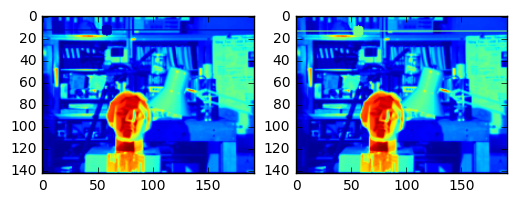

In [2]:
# %load depth.py
import cv2
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

def to_uint8( data ) :
    # maximum pixel
    latch = np.zeros_like( data )
    latch[:] = 255
    # minimum pixel
    zeros = np.zeros_like( data )

    # unrolled to illustrate steps
    d = np.maximum( zeros, data )
    d = np.minimum( latch, d )

    # cast to uint8
    return np.asarray( d, dtype="uint8" )

def drawlines(img1,img2,lines,pts1,pts2):
  ''' img1 - image on which we draw the epilines for the points in img2
      lines - corresponding epilines '''
  print img1.shape
  r,c, ch = img1.shape
  clr1 = cv2.pyrDown(cv2.imread('../images/stacked1.png', 0))
  clr2 = cv2.pyrDown(cv2.imread('../images/stacked2.png', 0))
  for r,pt1,pt2 in zip(lines,pts1,pts2):
      color = tuple(np.random.randint(0,255,3).tolist())
      x0,y0 = map(int, [0, -r[2]/r[1] ])
      x1,y1 = map(int, [c, -(r[2]+r[0]*c)/r[1] ])
      clr1 = cv2.line(clr1, (x0,y0), (x1,y1), color,1)
      clr1 = cv2.circle(clr1,tuple(pt1),5,color,-1)
      clr2 = cv2.circle(clr2,tuple(pt2),5,color,-1)
      return clr1, clr2

img1 = to_uint8(cv2.pyrDown(cv2.imread('../images/stacked1.png', cv2.COLOR_BGR2GRAY)))  #queryimage # left image
img2 = to_uint8(cv2.pyrDown(cv2.imread('../images/stacked2.png', cv2.COLOR_BGR2GRAY))) #trainimage # right image

sift = cv2.xfeatures2d.SIFT_create()
 
# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)

# FLANN parameters
FLANN_INDEX_KDTREE = 0
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50)
 
flann = cv2.FlannBasedMatcher(index_params,search_params)
matches = flann.knnMatch(des1,des2,k=2)
 
good = []
pts1 = []
pts2 = []
 
# ratio test as per Lowe's paper
for i,(m,n) in enumerate(matches):
    if m.distance < 0.8*n.distance:
        good.append(m)
        pts2.append(kp2[m.trainIdx].pt)
        pts1.append(kp1[m.queryIdx].pt)

pts1 = np.int32(pts1)
pts2 = np.int32(pts2)
F, mask = cv2.findFundamentalMat(pts1,pts2,cv2.FM_LMEDS)
 
# We select only inlier points
pts1 = pts1[mask.ravel()==1]
pts2 = pts2[mask.ravel()==1]

# Find epilines corresponding to points in right image (second image) and
# drawing its lines on left image
lines1 = cv2.computeCorrespondEpilines(pts2.reshape(-1,1,2), 2,F)
lines1 = lines1.reshape(-1,3)
img5,img6 = drawlines(img1,img2,lines1,pts1,pts2)

# Find epilines corresponding to points in left image (first image) and
# drawing its lines on right image
lines2 = cv2.computeCorrespondEpilines(pts1.reshape(-1,1,2), 1,F)
lines2 = lines2.reshape(-1,3)
img3,img4 = drawlines(img2,img1,lines2,pts2,pts1)

plt.subplot(121),plt.imshow(img5)
plt.subplot(122),plt.imshow(img3)
plt.show()
